# Task 3: Generator with Cross-Attention for Text-to-Image (GAN)

In [41]:
!pip install -q gdown


In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import gdown



In [43]:
file_id = "1tdL2D7qGrRdgEkC59BbgJEYhkxNGXWd1"
gdown.download(f"https://drive.google.com/uc?id={file_id}", "generator_model_weights.pth", quiet=False)


Downloading...
From: https://drive.google.com/uc?id=1tdL2D7qGrRdgEkC59BbgJEYhkxNGXWd1
To: /content/generator_model_weights.pth
0.00B [00:00, ?B/s]


'generator_model_weights.pth'

In [44]:
class CrossAttention(nn.Module):
    def __init__(self, query_dim, context_dim, heads=4):
        super().__init__()
        self.heads = heads
        self.scale = (query_dim // heads) ** -0.5
        self.to_q = nn.Linear(query_dim, query_dim, bias=False)
        self.to_k = nn.Linear(context_dim, query_dim, bias=False)
        self.to_v = nn.Linear(context_dim, query_dim, bias=False)
        self.to_out = nn.Linear(query_dim, query_dim)

    def forward(self, x, context):
        B, N, D = x.shape
        H = self.heads

        q = self.to_q(x).view(B, N, H, D // H).transpose(1, 2)
        k = self.to_k(context).view(B, -1, H, D // H).transpose(1, 2)
        v = self.to_v(context).view(B, -1, H, D // H).transpose(1, 2)

        scores = torch.matmul(q, k.transpose(-2, -1)) * self.scale
        attn = torch.softmax(scores, dim=-1)
        out = torch.matmul(attn, v)
        out = out.transpose(1, 2).contiguous().view(B, N, D)
        return self.to_out(out)


In [45]:
class Generator(nn.Module):
    def __init__(self, embed_dim=768, noise_dim=100):
        super().__init__()
        self.fc = nn.Linear(embed_dim + noise_dim, 256 * 8 * 8)
        self.attn = CrossAttention(query_dim=256, context_dim=embed_dim)

        self.upsample = nn.Sequential(
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, noise, text_embed):
        x = torch.cat((noise, text_embed), dim=1)
        x = self.fc(x).view(-1, 256, 8, 8)
        B, C, H, W = x.size()
        x_flat = x.view(B, C, -1).permute(0, 2, 1)
        text_context = text_embed.unsqueeze(1)
        x_attn = self.attn(x_flat, text_context)
        x = x_attn.permute(0, 2, 1).view(B, C, H, W)
        return self.upsample(x)


Saved weights to 'generator_model_weights.pth'


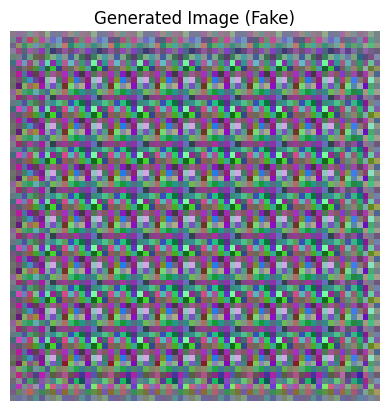

Generated Image Shape: torch.Size([1, 3, 64, 64])


In [46]:
# Instantiate and run generator
gen = Generator()
noise = torch.randn(1, 100)
embed = torch.randn(1, 768)
fake_img = gen(noise, embed)

# Save weights
torch.save(gen.state_dict(), "generator_model_weights.pth")
gen.eval()

print("Saved weights to 'generator_model_weights.pth'")

# Load later
# gen.load_state_dict(torch.load("generator_model_weights.pth"))
# gen.eval()

# Display generated image
grid = make_grid(fake_img, normalize=True)
plt.imshow(grid.permute(1, 2, 0).detach().cpu())
plt.title("Generated Image (Fake)")
plt.axis("off")
plt.show()
print("Generated Image Shape:", fake_img.shape)
